In [ ]:
!pip install seaborn

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [82]:
exp = 'exp2'
save = True
mode = 'random'

#df1 = pd.DataFrame({'id': ['A01', 'A02', 'A03', 'A04'],
#                    'Name': ['ABC', 'PQR', 'DEF', 'GHI']})
df_loss = pd.DataFrame(columns = ['hvd_size', 'seed', 'loss'])
df_summary = pd.DataFrame(columns = ['hvd_size', 'seed', 'err_l2', 'final_loss', 'texec'])
df_y = pd.DataFrame(columns = ['hvd_size', 'seed', 'xplot', 'y_pred', 'pointwise_err'])

N_plot = 450

hvd_list = [1, 2, 4, 8]

for hvd_size in hvd_list:
    for seed in range(1234,1242):
        name = exp + '/' + mode + '_seed' + str(seed) + '_size'+ str(hvd_size)
        my_dict = np.load(name + '.npy', allow_pickle = True)

        y_pred_ = my_dict.item().get('y_pred_')
        x_pred = np.linspace(-1, 7, N_plot)
        y_exact = np.sin(np.pi * x_pred)
        
        pointwise_err = np.log10(np.abs(y_pred_.ravel() - y_exact))
        loss = my_dict.item().get('loss')
        texec = my_dict.item().get('texec')

        err = my_dict.item().get('err')
        

        df1 = pd.DataFrame({
            'hvd_size': [hvd_size] * len(loss),
            'seed' : [seed] * len(loss),
            'iteration' : np.arange(len(loss)) * 100,
            'loss' : loss
        })
        
        df2 = pd.DataFrame({
            'hvd_size': [hvd_size],
            'seed' : [seed],
            'err_l2' : [err],
            'final_loss' : [loss[-1]],
            'texec' : [texec],
        })

                
        df3 = pd.DataFrame({
            'hvd_size': [hvd_size] * len(y_pred_),
            'seed' : [seed] * len(y_pred_),
            'x_pred': x_pred,
            'y_pred' : y_pred_.ravel(),
            'pointwise_err' : pointwise_err
        })
        
            

        df_loss = pd.concat([df_loss, df1])
        df_summary = pd.concat([df_summary, df2])
        df_y = pd.concat([df_y, df3])

        #plt.semilogy(loss)

    df_loss = df_loss.reset_index(drop=True)
    df_summary = df_summary.reset_index(drop=True)
    df_y = df_y.reset_index(drop=True)
    
    #print(my_dict.item().keys())    
    #print(my_dict.item().get('loss'))

In [83]:
rgb = [(236, 0, 84), (254, 64, 18), (38, 174, 65), (44, 95, 177)]
rgb = [(e[0] / 255.0, e[1] / 255.0, e[2] / 255.0) for e in rgb]
cmap = sns.blend_palette(rgb, n_colors=4)


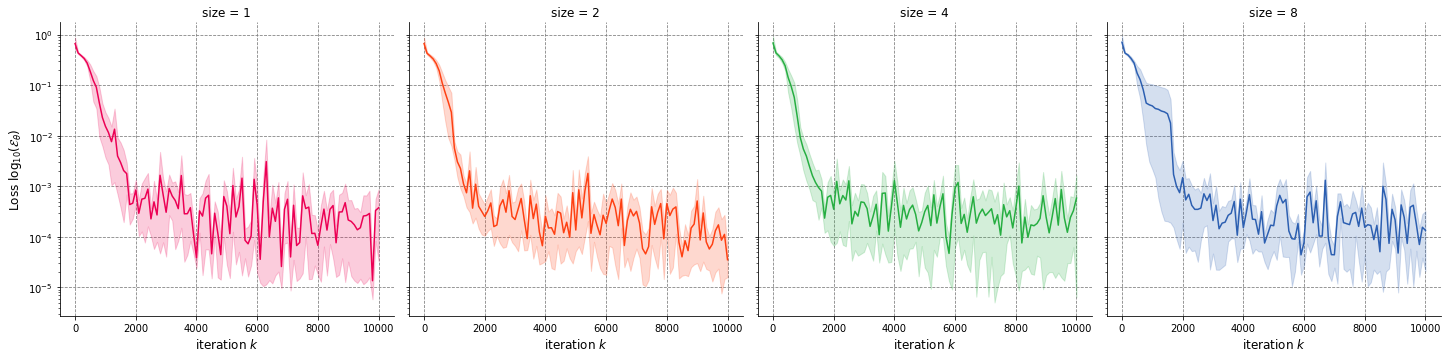

In [84]:
#f, ax = plt.subplots(1, 1, figsize=(13,5))
#g = sns.lineplot(data=df_loss, x = 'iteration', y = 'loss', hue = 'hvd_size')
g = sns.relplot(data=df_loss, x = 'iteration', y = 'loss', col = 'hvd_size', kind = 'line', palette = cmap, hue='hvd_size', legend=False)
g.set(yscale="log")

#plt.grid(color='gray', linestyle='dashed')  #just add this
#ax.xaxis.grid(color='gray', linestyle='dashed')
import matplotlib.patches as patches

for i in range(g.axes.shape[1]):
    ax = g.axes[0, i]
    ax.set_axisbelow(True)
    ax.set_title(ax.title.get_text()[4:], fontsize=12)
    ax.grid(color='gray', linestyle='dashed')
    ax.set_xlabel('iteration $k$', fontsize=12)
    ax.set_ylabel(r'Loss $\log_{10}(\mathcal{E}_\theta)$', fontsize=12)
    
if save:
    plt.savefig('plots/' + exp + '_' + mode + '0.svg')

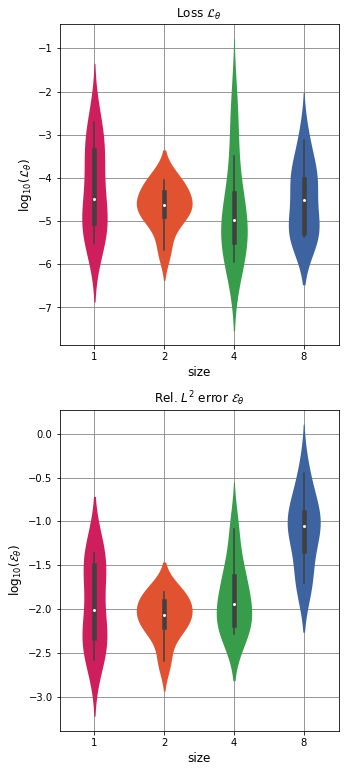

In [85]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(5,13))
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

df_summary['log10_final_loss'] = np.log10(df_summary['final_loss'])
df_summary['log10_err_l2'] = np.log10(df_summary['err_l2'])

g = sns.violinplot(data = df_summary, x = 'hvd_size', y = 'log10_final_loss', ax= ax1, palette=cmap)

for collection in g.collections:
    #collection.set_edgecolor('white')
    collection.set_linewidth(0)
ax1.grid(color='gray')

g = sns.violinplot(data = df_summary, x = 'hvd_size', y = 'log10_err_l2',palette=cmap, ax=ax2)

for collection in g.collections:
    #collection.set_edgecolor('white')
    collection.set_linewidth(0)

ax2.grid(color='gray')
#plt.savefig('exp21.svg')

ax1.set_xlabel(r'size', fontsize=12)
ax1.set_ylabel(r'$\log_{10}(\mathcal{L}_\theta)$', fontsize=12)
ax1.set_title(r'Loss $\mathcal{L}_\theta$', fontsize=12)

ax2.set_xlabel('size', fontsize=12)
ax2.set_ylabel(r'$\log_{10}(\mathcal{E}_\theta)$', fontsize=12)
ax2.set_title(r'Rel. $L^2$ error $\mathcal{E}_\theta$', fontsize=12)

if save:
    plt.savefig('plots/' + exp + '_' + mode + '1.svg')

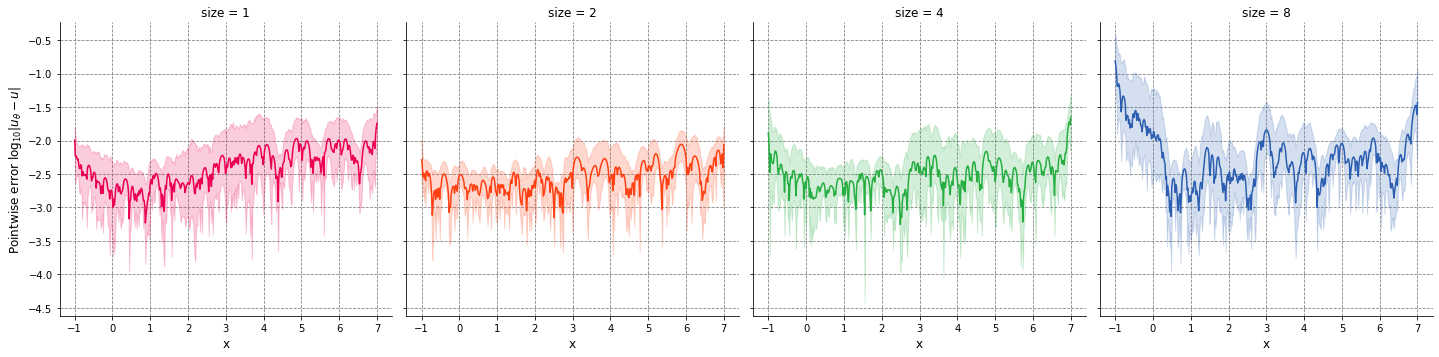

In [86]:
#f, ax = plt.subplots(1, 1, figsize=(13,5))
#g = sns.lineplot(data=df_loss, x = 'iteration', y = 'loss', hue = 'hvd_size')
g = sns.relplot(data=df_y, x = 'x_pred', y = 'pointwise_err', col = 'hvd_size', kind = 'line', palette = cmap, hue='hvd_size', legend=False)

#plt.grid(color='gray', linestyle='dashed')  #just add this
#ax.xaxis.grid(color='gray', linestyle='dashed')

for i in range(g.axes.shape[1]):
    ax = g.axes[0, i]
    ax.set_axisbelow(True)
    ax.set_title(ax.title.get_text()[4:], fontsize=12)
    ax.grid(color='gray', linestyle='dashed')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel(r'Pointwise error $\log_{10}|u_\theta - u|$', fontsize=12)
    
if save:
    plt.savefig('plots/' + exp + '_' + mode + '2.svg')

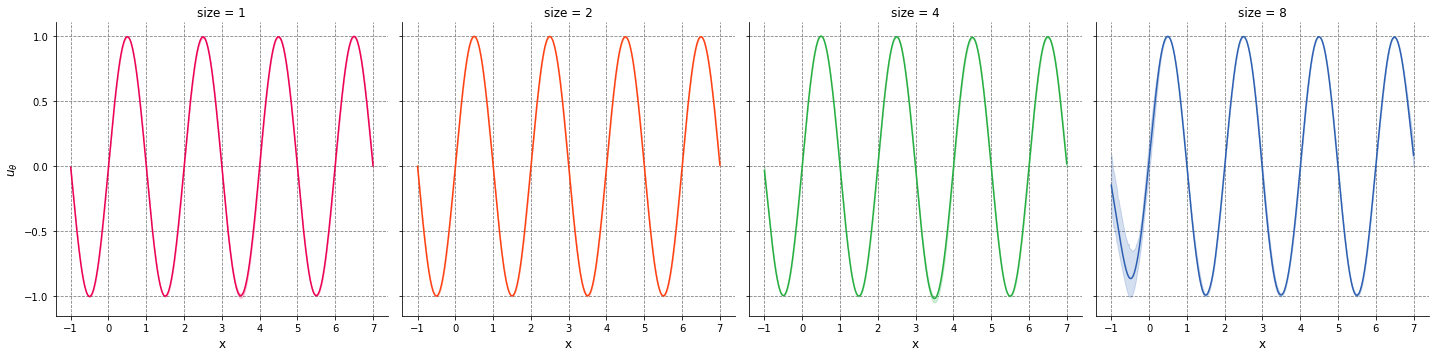

In [87]:
g = sns.relplot(data=df_y, x = 'x_pred', y = 'y_pred', col = 'hvd_size', kind = 'line', palette = cmap, hue='hvd_size', legend=False)

for i in range(g.axes.shape[1]):
    ax = g.axes[0, i]
    ax.set_axisbelow(True)
    ax.set_title(ax.title.get_text()[4:], fontsize=12)
    ax.grid(color='gray', linestyle='dashed')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel(r'$u_\theta$', fontsize=12)
    
if save:
    plt.savefig('plots/' + exp + '_' + mode + '3.svg')

In [95]:

seed = 1234
import numpy as np

np.random.seed(seed)


def data_uniform(size, rank):
    if size == 1:
        x_col = np.linspace(-1, 7, Ntot).reshape((-1, 1))
    if size == 2:
        x_col = np.linspace(-1 + 4 * rank, -1 + 4 * (rank + 1), int(Ntot /2.)).reshape((-1, 1))
    if size == 4:
        x_col = np.linspace(-1 + 2 * rank, -1 + 2 * (rank + 1), int(Ntot /4.)).reshape((-1, 1))
    if size == 8:
        x_col = np.linspace(-1 + rank, -1 + (rank + 1), int(Ntot /8.)).reshape((-1, 1))
    return x_col
    
def data_random(size, rank):
    if size == 1:
        x_col = (np.random.random(Ntot) * 8 - 1).reshape((-1,1))
        
    if size == 2:
        x_col = (np.random.random(int(Ntot/2)) * 8 - 1).reshape((-1,1))
    
    if size == 4:
        x_col = (np.random.random(int(Ntot/4)) * 8 - 1).reshape((-1,1))
        
    if size == 8:
        x_col = (np.random.random(int(Ntot/8)) * 8 - 1).reshape((-1,1))
    return x_col
        
N = 50
Ntot = 8 * N

def data(size, rank):
    if mode == 'uniform':
        x_col = data_uniform(size, rank)
    elif mode == 'random':
        x_col = data_random(size, rank)
    else:
        print('error')
    return x_col

df_x = pd.DataFrame(columns = ['hvd_size', 'rank', 'x_train'])


for size in hvd_list:
    for rank in range(size):
        x_col = data(size, rank)  
        print(size, rank, 'and max min: ', x_col.min(), x_col.max())
        df4 = pd.DataFrame({
            'hvd_size': [size] * x_col.shape[0],
            'rank' : [rank] * x_col.shape[0],
            'x_train' : x_col.ravel()})
        df_x = pd.concat([df_x, df4])
df_x = df_x.reset_index(drop=True)


1 0 and max min:  -0.982484553415027 6.9971967501615495
2 0 and max min:  -0.8785992737963717 6.906798103644015
2 1 and max min:  -0.9876498994305907 6.999709790229115
4 0 and max min:  -0.9311569022970358 6.989046074880921
4 1 and max min:  -0.9542793258787423 6.982457450511933
4 2 and max min:  -0.9484961718648917 6.858891607399966
4 3 and max min:  -0.9864825443451757 6.653838990564081
8 0 and max min:  -0.8489421457104429 6.9676227279052645
8 1 and max min:  -0.7460679171801603 6.6653927258761785
8 2 and max min:  -0.8931543748309201 6.94834921656418
8 3 and max min:  -0.9636282687901341 6.917956926632078
8 4 and max min:  -0.8357185845498822 6.912814865434688
8 5 and max min:  -0.9981820006866258 6.709646938004203
8 6 and max min:  -0.9123318877814199 6.984549726775459
8 7 and max min:  -0.9523958190182533 6.824522917618115


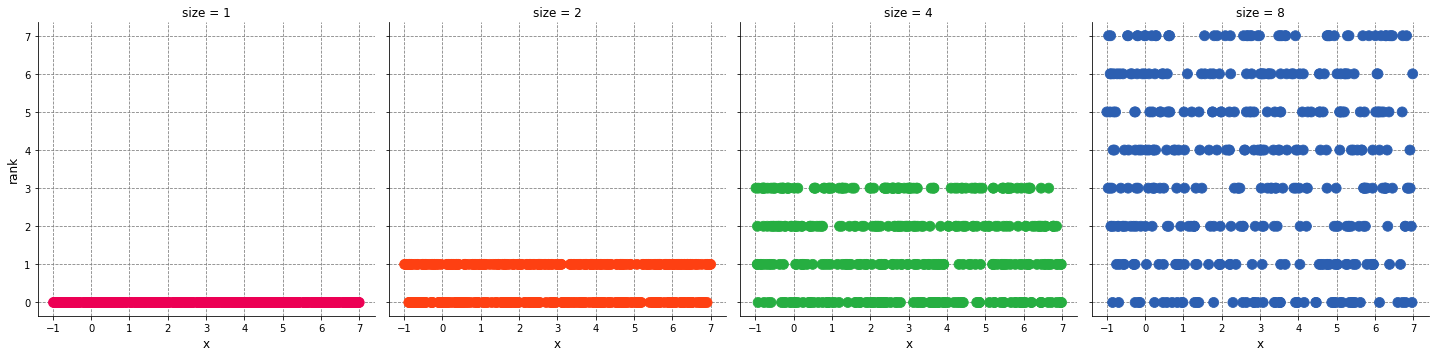

In [96]:
g = sns.relplot(data=df_x, x = 'x_train', y = 'rank', col = 'hvd_size', palette = cmap, hue='hvd_size', legend=False, edgecolor=None, s=100)

for i in range(g.axes.shape[1]):
    ax = g.axes[0, i]
    ax.set_axisbelow(True)
    ax.set_title(ax.title.get_text()[4:], fontsize=12)
    ax.grid(color='gray', linestyle='dashed')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('rank', fontsize=12)
    

if save:
    plt.savefig('plots/' + exp + '_' + mode + '4.svg')    


1 0 and max min:  -0.8898524032745421 6.665114829469641
2 0 and max min:  -0.9458875040799777 6.936651729506892
2 1 and max min:  -0.9503318673029648 6.856037932175636
4 0 and max min:  0.19866972791941784 6.345584603044585
4 1 and max min:  -0.5430748952891209 6.611430110028746
4 2 and max min:  -0.7628239957166754 6.726692255937021
4 3 and max min:  0.46070985264247 6.363220568744702
8 0 and max min:  1.3290019591829987 6.200702694477662
8 1 and max min:  -0.5599488367502108 4.260414217262555
8 2 and max min:  0.38453781451833713 5.831188537005134
8 3 and max min:  0.07216964799074255 6.957230629154356
8 4 and max min:  -0.9252114039980439 6.817931447380697
8 5 and max min:  0.13948298673453774 4.827429410957376
8 6 and max min:  -0.13350804653816972 6.795961104698078
8 7 and max min:  3.5469406525834595 6.31522490615459


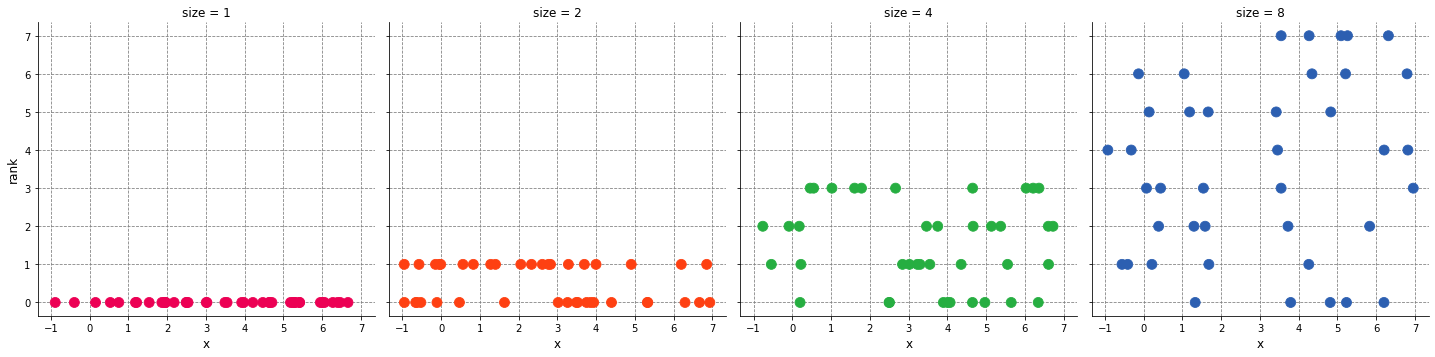

In [97]:

seed = 1234
import numpy as np

np.random.seed(seed)


def data_uniform(size, rank):
    if size == 1:
        x_col = np.linspace(-1, 7, Ntot).reshape((-1, 1))
    if size == 2:
        x_col = np.linspace(-1 + 4 * rank, -1 + 4 * (rank + 1), int(Ntot /2.)).reshape((-1, 1))
    if size == 4:
        x_col = np.linspace(-1 + 2 * rank, -1 + 2 * (rank + 1), int(Ntot /4.)).reshape((-1, 1))
    if size == 8:
        x_col = np.linspace(-1 + rank, -1 + (rank + 1), int(Ntot /8.)).reshape((-1, 1))
    return x_col
    
def data_random(size, rank):
    if size == 1:
        x_col = (np.random.random(Ntot) * 8 - 1).reshape((-1,1))
        
    if size == 2:
        x_col = (np.random.random(int(Ntot/2)) * 8 - 1).reshape((-1,1))
    
    if size == 4:
        x_col = (np.random.random(int(Ntot/4)) * 8 - 1).reshape((-1,1))
        
    if size == 8:
        x_col = (np.random.random(int(Ntot/8)) * 8 - 1).reshape((-1,1))
    return x_col
        
N = 5
Ntot = 8 * N

def data(size, rank):
    if mode == 'uniform':
        x_col = data_uniform(size, rank)
    elif mode == 'random':
        x_col = data_random(size, rank)
    else:
        print('error')
    return x_col

df_x = pd.DataFrame(columns = ['hvd_size', 'rank', 'x_train'])


for size in hvd_list:
    for rank in range(size):
        x_col = data(size, rank)  
        print(size, rank, 'and max min: ', x_col.min(), x_col.max())
        df4 = pd.DataFrame({
            'hvd_size': [size] * x_col.shape[0],
            'rank' : [rank] * x_col.shape[0],
            'x_train' : x_col.ravel()})
        df_x = pd.concat([df_x, df4])
df_x = df_x.reset_index(drop=True)

g = sns.relplot(data=df_x, x = 'x_train', y = 'rank', col = 'hvd_size', palette = cmap, hue='hvd_size', legend=False, edgecolor=None, s=100)

for i in range(g.axes.shape[1]):
    ax = g.axes[0, i]
    ax.set_axisbelow(True)
    ax.set_title(ax.title.get_text()[4:], fontsize=12)
    ax.grid(color='gray', linestyle='dashed')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('rank', fontsize=12)
    

if save:
    plt.savefig('plots/' + exp + '_' + mode + '5.svg')    
